In [1]:
%load_ext autoreload
%autoreload 2

from meteo_lib.meteo_lib import getBlock, get_HourlyData, get_10minData
from meteo_lib.my_path_utils import DATA, OUT

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import datetime as dt
import matplotlib.dates as mdates
import math
from datetime import datetime, timedelta, date, time
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
import os
from pathlib import Path
mpl.rcParams["font.family"] = "IPAexGothic"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避


In [3]:
summer_threshold: float = 25.0    # 閾値：夏の終わり
winter_threshold: float = 15.0    # 閾値：冬の始まり

place = '秋田'
start_year, end_year = 1927, 2024

drive_path =Path("/Users/takumi/projects/JMA-data/outputs")

inputpath = drive_path / f'日毎データ_{place}.parquet'
print(inputpath)
df = pd.read_parquet(inputpath)
#df = df.reset_index(names='日時')

df = df.sort_values('日時').reset_index(drop=True)

df['Tmean_5d'] = df['平均気温'].rolling(window=7, min_periods=5).mean()
df['年'] = df['日時'].dt.year
df['月'] = df['日時'].dt.month
df['日'] = df['日時'].dt.day
df = df[(df['年']>=start_year) & (df['年']<=end_year)]

is_summer = (df['Tmean_5d'] < summer_threshold) & (df['月'] >= 9)
is_winter = (df['Tmean_5d'] < winter_threshold) & (df['月'] >= 9)
last_summer = df.loc[is_summer].groupby('年')['日時'].min().rename('Last_Summer')
first_winter = df.loc[is_winter].groupby('年')['日時'].min().rename('First_Winter')
span_autumn = ((first_winter - last_summer).dt.days).rename('Span_Autumn')
idx = pd.Index(range(start_year, end_year + 1), name='年')
out = pd.concat([last_summer, first_winter, span_autumn],  axis=1).reindex(idx)
print(out)

/Users/takumi/projects/JMA-data/outputs/日毎データ_秋田.parquet
     Last_Summer First_Winter  Span_Autumn
年                                         
1927  1927-09-01   1927-09-26           25
1928  1928-09-12   1928-10-05           23
1929  1929-09-01   1929-10-14           43
1930  1930-09-01   1930-10-11           40
1931  1931-09-01   1931-10-12           41
...          ...          ...          ...
2020  2020-09-14   2020-10-18           34
2021  2021-09-01   2021-10-18           47
2022  2022-09-01   2022-10-10           39
2023  2023-09-21   2023-10-22           31
2024  2024-09-06   2024-10-29           53

[98 rows x 3 columns]


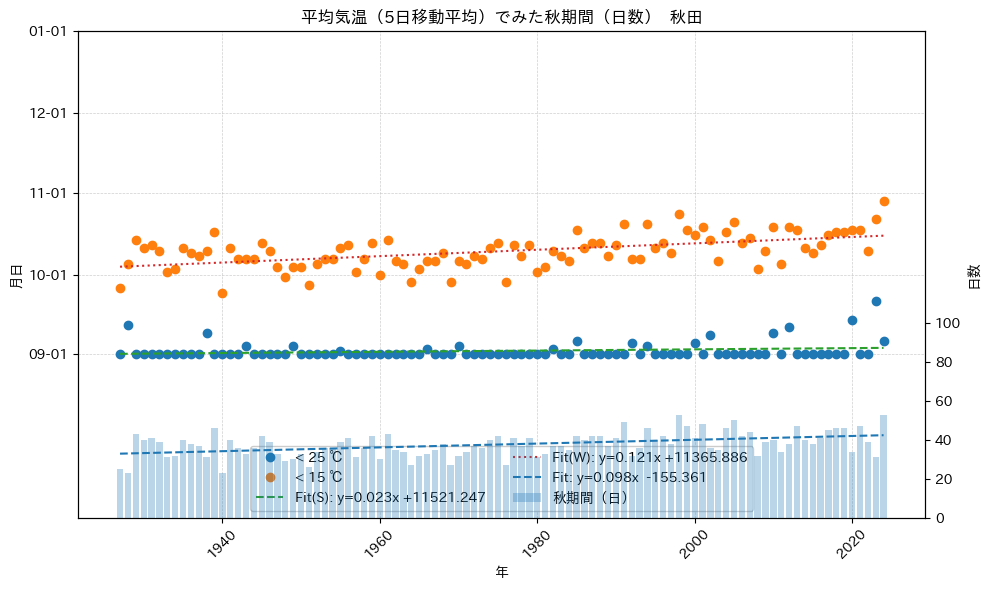

In [4]:
REF_YEAR = 2001

def to_refdate(s: pd.Series) -> pd.Series:
    # 年を消して「月日だけ」を基準年に載せ替え（NaTはNaTのまま）
    return pd.to_datetime(
        np.where(s.notna(), s.dt.strftime(f"{REF_YEAR}" + "-%m-%d"), pd.NaT),
        errors="coerce"
    )

fig, ax1 = plt.subplots(figsize=(10, 6))

Last_summer_ref = to_refdate(out["Last_Summer"])
First_winter_ref = to_refdate(out["First_Winter"])
x = out.index.astype(int).values
"""
# 1) 基準年に投影（回帰・表示を同じ尺度に）
last_ref_s = to_refdate(out["Last_Summer"])
last_ref_w = to_refdate(out["First_Winter"])

# 2) 欠損除去＆数値化（matplotlibの日付番号へ）
mask_s = last_ref_s.notna()
x_fit = out.index[mask_s].astype(int).to_numpy()          # 年（数値）
y_fit_num_s = mdates.date2num(last_ref_s[mask_s])             # 日付→float

mask_w = last_ref_w.notna()
y_fit_num_w = mdates.date2num(last_ref_w[mask_s])             # 日付→float
"""
# --- 基準年投影 ---
last_ref_s = to_refdate(out["Last_Summer"])
last_ref_w = to_refdate(out["First_Winter"])

# --- マスク ---
mask_s = last_ref_s.notna()
mask_w = last_ref_w.notna()

# --- X（年：int配列）---
x_all = out.index.to_numpy(int)

# ===== 左軸：散布 =====
ax1.cla()  # 念のためクリア（他の書式は後で再設定）
if mask_s.any():
    ax1.plot(x_all[mask_s], last_ref_s[mask_s], marker='o', linestyle='None',
             label=f"< {summer_threshold:.0f} ℃")
if mask_w.any():
    ax1.plot(x_all[mask_w], last_ref_w[mask_w], marker='o', linestyle='None',
             label=f"< {winter_threshold:.0f} ℃")

# ===== 回帰ユーティリティ =====
def safe_polyfit(x, dt_series):
    import numpy as np, matplotlib.dates as mdates
    y = mdates.date2num(dt_series)
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return None
    a, b = np.polyfit(x[m], y[m], 1)
    return a, b, mdates.num2date(a * x[m] + b), x[m]

# ===== 夏の回帰（2点以上の時だけ）=====
res_s = safe_polyfit(x_all[mask_s], last_ref_s[mask_s])
if res_s:
    a_s, b_s, y_line_dt_s, x_fit_s = res_s
    ax1.plot(x_fit_s, y_line_dt_s, '--', label=f"Fit(S): y={a_s:.3f}x {b_s:+.3f}")

# ===== 冬の回帰（★夏の x は使わない）=====
res_w = safe_polyfit(x_all[mask_w], last_ref_w[mask_w])
if res_w:
    a_w, b_w, y_line_dt_w, x_fit_w = res_w
    ax1.plot(x_fit_w, y_line_dt_w, ':', label=f"Fit(W): y={a_w:.3f}x {b_w:+.3f}")

# ===== 左軸の体裁 =====
ax1.set_ylabel("月日")
ax1.set_xlabel("年")
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_ylim(pd.Timestamp(REF_YEAR, 7, 1), pd.Timestamp(REF_YEAR+1, 1, 1))
ticks = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR+1}-01-01", freq="MS")
ax1.set_yticks(ticks)
ax1.yaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)



# 右軸：秋期間（日）（棒）
ax2 = ax1.twinx()
ax2.bar(x, out['Span_Autumn'].astype(float), alpha=0.3, label="秋期間（日）")
ax2.set_ylabel("日数")
ax2.set_ylim(0, 250)
ticks = list(range(0, 101, 20))
ax2.set_yticks(ticks)

a, b = np.polyfit(x, out['Span_Autumn'], 1)
y = a * x + b
ax2.plot(x, y, linestyle='--', label=f"Fit: y={a:.3f}x  {b:+.3f}")

# 凡例（統合）
handles, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
seen, h2, l2 = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); h2.append(h); l2.append(l)
#ax1.legend(h2, l2, loc="center left")
ax1.legend(h2, l2, loc="lower center", ncol=2,
           facecolor='white', framealpha=1.0)  # ncolで複数列表示

ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.title(f"平均気温（5日移動平均）でみた秋期間（日数）  {place}")
plt.tight_layout()

plt.savefig(OUT / f'秋期間_移動平均_{place}.png')

plt.show()